In [1]:
import torch
import torch.nn as nn
#
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # required for 3D plotting
from matplotlib import cm
#
import numpy as np

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Training parameters
EPOCHS = 3000
STEP_SIZE = 1000
GAMMA = 0.9

In [4]:
# PDE parameters
beta = torch.tensor([0.,1.])

In [5]:
class PINNModel_old(nn.Module):
    def __init__(self, net_layers, initialization_type="xavier"):
        """
        Initialize the PINN model.

        :param net_layers: List defining the number of neurons in each layer.
        :param initialization_type: Initialization method for the network weights.
        """
        super(PINNModel, self).__init__()
        self.layers = nn.ModuleList()
        self.initialization_type = initialization_type

        # Define all layers based on net_layers
        for i in range(1, len(net_layers)):
            self.layers.append(
                nn.Linear(net_layers[i - 1], net_layers[i])
            )

        # Initialize weights
        self.initialize_weights()

    def forward(self, x, y):
        """
        Forward pass of the PINN model.
        """
        # Combine r and theta into a single input tensor
        inputs = torch.cat((x, y), dim=1)

        # Pass through the network layers
        out = inputs
        for layer in self.layers[:-1]:
            #out = torch.tanh(layer(out))
            out = torch.relu(layer(out))

        # Last layer without activation
        out = self.layers[-1](out)
        return out

    def initialize_weights(self):
        """
        Initialize the weights of the network layers.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if self.initialization_type == "xavier":
                    nn.init.xavier_uniform_(layer.weight)
                elif self.initialization_type == "he":
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity="tanh")
                else:  # Default initialization
                    nn.init.uniform_(layer.weight, -0.1, 0.1)
                nn.init.zeros_(layer.bias)
class PINNModel(nn.Module):
    def __init__(self, net_layers, activation='tanh', initialization_type="xavier"):
        """
        Initialize the PINN model.

        :param net_layers: List defining the number of neurons in each layer.
        :param activation: Activation to use for hidden layers.
                           Either a string ('tanh', 'relu', 'sigmoid', …)
                           or an nn.Module instance.
        :param initialization_type: Initialization method for the network weights.
                                    Options: "xavier", "he", or anything else for uniform.
        """
        super(PINNModel, self).__init__()
        self.initialization_type = initialization_type

        # Resolve activation
        if isinstance(activation, str):
            activation = activation.lower()
            if activation == 'tanh':
                self.activation = nn.Tanh()
                self._act_name = 'tanh'
            elif activation == 'relu':
                self.activation = nn.ReLU()
                self._act_name = 'relu'
            elif activation == 'sigmoid':
                self.activation = nn.Sigmoid()
                self._act_name = 'sigmoid'
            else:
                raise ValueError(f"Unsupported activation string: {activation}")
        elif isinstance(activation, nn.Module):
            self.activation = activation
            # best-effort name for initialization
            self._act_name = activation.__class__.__name__.lower()
        else:
            raise TypeError("activation must be a string or nn.Module")

        # Build layers
        self.layers = nn.ModuleList()
        for in_dim, out_dim in zip(net_layers[:-1], net_layers[1:]):
            self.layers.append(nn.Linear(in_dim, out_dim))

        # Initialize weights
        self.initialize_weights()

    def forward(self, x, y):
        """
        Forward pass of the PINN model.
        """
        # Combine r and theta into a single input tensor
        out = torch.cat((x, y), dim=1)

        # Hidden layers with activation
        for layer in self.layers[:-1]:
            out = self.activation(layer(out))

        # Last layer (no activation)
        return self.layers[-1](out)

    def initialize_weights(self):
        """
        Initialize the weights of the network layers.
        """
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                if self.initialization_type == "xavier":
                    nn.init.xavier_uniform_(layer.weight)
                elif self.initialization_type == "he":
                    # use the activation name for nonlinearity param
                    nonlin = self._act_name if self._act_name in ('relu', 'leaky_relu') else 'relu'
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity=nonlin)
                else:  # Default uniform initialization
                    nn.init.uniform_(layer.weight, -0.1, 0.1)
                nn.init.zeros_(layer.bias)                

In [6]:
# Exact sol
def u_exact(x,y):
    return 1.*(x > 0.5)
# FE approximation
def uh(x,y):
    return 0.5 + 0.*x

In [7]:
# MC sampling pointa 
def random_domain_points(n=2048):
    x = torch.rand(n,1,requires_grad=True, device=device)
    y = torch.rand(n,1,requires_grad=True, device=device)
    return x,y

In [8]:
# NN architecture
torch.manual_seed(42)
model = PINNModel([2,64,64,64,1], activation='tanh').to(device)
#model = PINNModel([2,64,64,1], activation='relu').to(device)

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [10]:
loss_list = []
for epoch in range(EPOCHS):
    optimizer.zero_grad() # to make the gradients zero
    #
    x,y = random_domain_points(10000)
    r = model(x,y)*(1 - y)
    # Derivatives
    r_x = torch.autograd.grad(outputs=r, 
                              inputs=x,
                              create_graph=True,
                              grad_outputs=torch.ones_like(r)
                              )[0]
    r_y = torch.autograd.grad(outputs=r, 
                               inputs=y,
                               create_graph=True,
                               grad_outputs=torch.ones_like(r)
                               )[0]
    res1 = (1/2)*torch.mean((beta[0]*r_x + beta[1]*r_y)**2)
    res2 = torch.mean(uh(x,y) * (beta[0]*r_x + beta[1]*r_y))
    res3 = torch.mean(u_exact(x,y) * (beta[0]*r_x + beta[1]*r_y))
    loss_dom = res1 - res2 + res3
    # LOSS
    loss = loss_dom
    loss_list.append(loss.item())
    #
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6e}")
    #
    loss.backward() # This is for computing gradients using backward propagation
    optimizer.step() # 

Epoch 0, Loss: 4.544365e-02
Epoch 500, Loss: -1.013860e-01
Epoch 1000, Loss: -1.232663e-01
Epoch 1500, Loss: -1.238883e-01
Epoch 2000, Loss: -1.241501e-01
Epoch 2500, Loss: -1.242390e-01


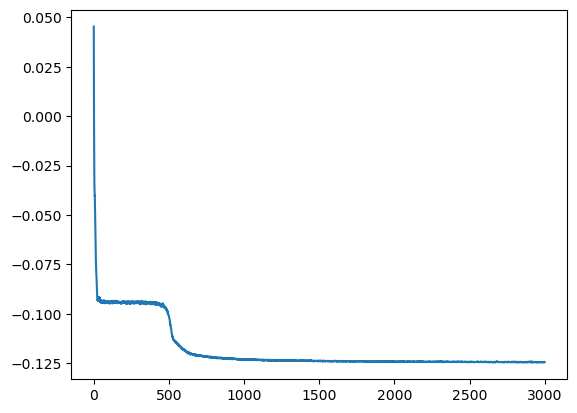

In [11]:
plt.plot(loss_list)

In [12]:
resolution = 128
#
x_test = torch.linspace(0.,1.,resolution)
y_test = torch.linspace(0.,1.,resolution)
X,Y = torch.meshgrid(x_test,y_test, indexing='ij')
X_ = X.reshape(-1,1)
Y_ = Y.reshape(-1,1)
#
r_test = model(X_.to(device),Y_.to(device))*(1 - Y_.to(device))
Z = r_test.reshape(resolution, resolution)

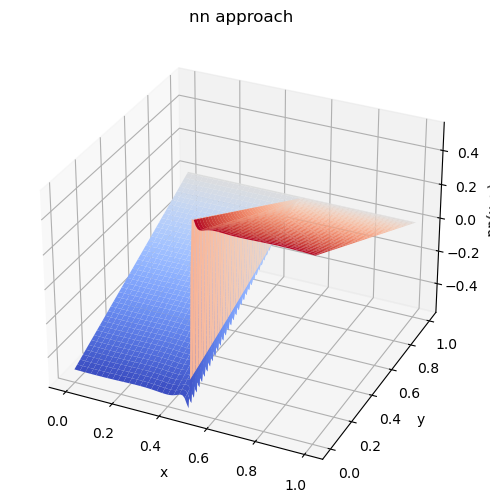

In [13]:
# Convert to NumPy for plotting
X_np = X.numpy()
Y_np = Y.numpy()
Z_np = Z.detach().cpu().numpy()

# Plotting
ax = plt.figure(figsize=(7,6)).add_subplot(projection='3d')
ax.plot_surface(X_np, Y_np, Z_np, 
                cmap=cm.coolwarm,
                linewidth=0, 
                #antialiased=False
               )
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('nn(x, y)')
ax.set_title('nn approach')
ax.view_init(elev=30, azim=-65)
#plt.tight_layout()
plt.show()

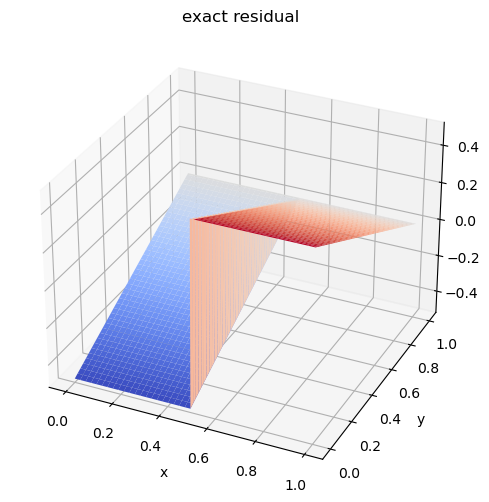

In [14]:
# Convert to NumPy for plotting
X_np = X.numpy()
Y_np = Y.numpy()
R_np = 0.5*(1 - Y_np)*(X_np > 0.5) + 0.5*(Y_np - 1)*(X_np <= 0.5) 

# Plotting
ax = plt.figure(figsize=(7,6)).add_subplot(projection='3d')
ax.plot_surface(X_np, Y_np, R_np, 
                cmap=cm.coolwarm,
                linewidth=0, 
                #antialiased=False
               )
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('r(x, y)')
ax.set_title('exact residual')
ax.view_init(elev=30, azim=-65)
#plt.tight_layout()
plt.show()

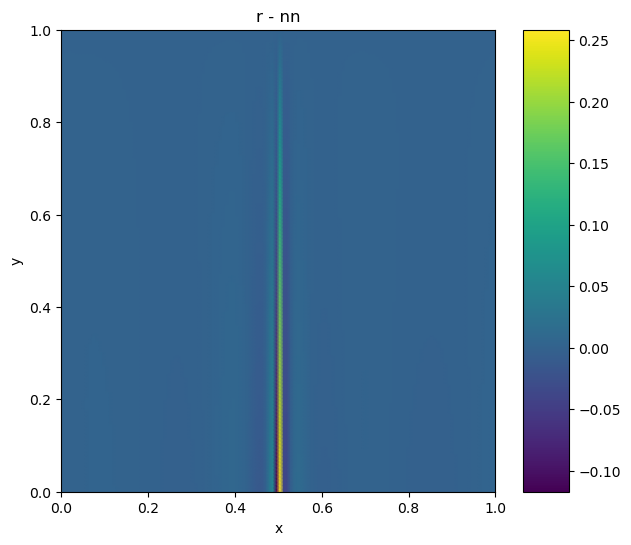

In [15]:
fig = plt.figure(figsize=(7,6))
# 
ax = fig.add_subplot(111)
# surface plot
im = ax.pcolormesh(X_np,Y_np,R_np - Z_np,
                   shading='gouraud',
                   )
ax.set_xlabel('x')
ax.set_ylabel('y')
#ax.set_zlabel('r(x, y)')
ax.set_title('r - nn')
# colorbar
cbar = fig.colorbar(im, aspect=10)